<a href="https://www.kaggle.com/code/ravaghi/s05e04-podcast-listening-time-ridge?scriptVersionId=233691473" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ydf scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Imports and configs

In [2]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, TargetEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import keras
import json
import glob
import ydf
import os
import gc

ydf.verbose(2)
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e4/train.csv"
    test_path = "/kaggle/input/playground-series-s5e4/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e4/sample_submission.csv"

    original_path = "/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv"
    
    target = "Listening_Time_minutes"
    metric = "RMSE"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
def create_features(df):
    data = df.copy()
    
    data['Episode_Length_minutes'].fillna(data['Episode_Length_minutes'].mean(), inplace=True)
    data['Ad_Density'] = data['Number_of_Ads'] / data['Episode_Length_minutes']
    data['Host_Guest_Popularity_Sum'] = data['Host_Popularity_percentage'] + data['Guest_Popularity_percentage']
    data['Content_To_Ad_Ratio'] = data['Episode_Length_minutes'] / (data['Number_of_Ads'] + 1)
    data['Episode_Number'] = data['Episode_Title'].str.extract(r'Episode\s+(\d+)').astype(float)

    time_period_mapping = {
        'Morning': 'Early',
        'Afternoon': 'Middle',
        'Evening': 'Late',
        'Night': 'Late'
    }
    data['Time_Period'] = data['Publication_Time'].map(time_period_mapping)
    data['Day_Time'] = data['Publication_Day'] + '_' + data['Publication_Time']
    
    return data

In [5]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train = create_features(train)
test = create_features(test)

cat_cols = test.select_dtypes(include="object").columns.tolist()
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = None
y_original = None

# Training base models

In [6]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config
        
    def train(self, X, y, X_test, X_original=None, y_original=None):       
        print(f"Training {self.model.__class__.__name__}\n")
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        coeffs = np.zeros((1, X.shape[1]))
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if X_original is not None and y_original is not None:
                X_train = pd.concat([X_train, X_original])
                y_train = pd.concat([y_train, y_original])
            
            y_preds, temp_test_preds, score, _coeff = self._fit_predict(fold_idx, X_train, y_train, X_val, y_val, X_test)
            oof_preds[val_idx] = y_preds
            test_preds += temp_test_preds / self.config.n_folds
            scores.append(score)
            if _coeff is not None:
                coeffs += _coeff / self.config.n_folds
            
            del X_train, y_train, X_val, y_val, y_preds, temp_test_preds
            gc.collect() 
            
        overall_score = root_mean_squared_error(y, oof_preds)
        average_score = np.mean(scores)
        
        self._save_results(oof_preds, test_preds, overall_score)
        print(f"\n------ Overall {CFG.metric}: {overall_score:.6f} - Average {CFG.metric}: {average_score:.6f}")
        
        return oof_preds, test_preds, scores, coeffs
    
    def tune(self, X, y):                       
        oof_preds = np.zeros(X.shape[0])
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
                
            model = clone(self.model)
            model.fit(X_train, y_train)

            oof_preds[val_idx] = model.predict(X_val)
                
            del X_train, y_train, X_val, y_val
            gc.collect() 
            
        return root_mean_squared_error(y, oof_preds)
        
    def _save_results(self, oof_preds, test_preds, cv_score):            
        if isinstance(self.model, (Ridge, Lasso)):
            pass
        else:
            model_name = self.model.__class__.__name__.lower().replace("regressor", "")
            if model_name == "lgbm":
                model_name = "lgbm-" + self.model.boosting_type
            
            if model_name == "bagging":
                model_name = "keras-ann"
            
            os.makedirs(f"oof/{model_name}", exist_ok=True)
            
            joblib.dump(oof_preds, f"oof/{model_name}/{model_name}_oof_preds_{cv_score:.6f}.pkl")
            joblib.dump(test_preds, f"oof/{model_name}/{model_name}_test_preds_{cv_score:.6f}.pkl")
            
    def _fit_predict(self, fold_idx, X_train, y_train, X_val, y_val, X_test):
        if isinstance(self.model, LGBMRegressor):
            y_preds, test_preds = self._fit_lightgbm(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, XGBRegressor):
            y_preds, test_preds = self._fit_xgboost(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, CatBoostRegressor):
            y_preds, test_preds = self._fit_catboost(X_train, y_train, X_val, y_val, X_test)
        else:
            model = clone(self.model)
            model.fit(X_train, y_train)
            y_preds = model.predict(X_val)
            test_preds = model.predict(X_test)
            
        score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
        
        if isinstance(self.model, (CatBoostRegressor, LGBMRegressor, XGBRegressor)):
            print(f"\n--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}\n\n")
        else:
            print(f"--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}")
            
        coeff = model.coef_ if isinstance(self.model, (Ridge, Lasso)) else None
        return y_preds, test_preds, score, coeff
        
    def _fit_lightgbm(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
            X_train, 
            y_train, 
            eval_metric="rmse",
            eval_set=[(X_val, y_val)], 
            callbacks=[
                log_evaluation(period=200), 
                early_stopping(stopping_rounds=100)
            ]
        )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_xgboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=200
            )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_catboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)

        cat_cols = X_train.select_dtypes(include="category").columns.tolist()
        if len(cat_cols) > 0:
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_val, y_val, cat_features=cat_cols)
            test_pool = Pool(X_test, cat_features=cat_cols)
        else:
            train_pool = Pool(X_train, y_train)
            val_pool = Pool(X_val, y_val)
            test_pool = Pool(X_test)

        model.fit(
            X=train_pool, 
            eval_set=val_pool, 
            verbose=200, 
            early_stopping_rounds=100,
            use_best_model=True
        )
        
        y_preds = model.predict(val_pool)
        test_preds = model.predict(test_pool)
        del model
        
        return y_preds, test_preds

In [7]:
histgb_params = {
    "categorical_features": "from_dtype",
    "l2_regularization": 67.18469453204166,
    "learning_rate": 0.010608367366279405,
    "max_depth": 144,
    "max_features": 0.4821945354902636,
    "max_iter": 2900,
    "max_leaf_nodes": 476,
    "min_samples_leaf": 113,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.35666189554833105,
    "learning_rate": 0.0712803646567931,
    "min_child_samples": 9,
    "min_child_weight": 0.698059594562524,
    "n_estimators": 8000,
    "n_jobs": -1,
    "num_leaves": 99,
    "random_state": 42,
    "reg_alpha": 2.541398781620041,
    "reg_lambda": 5.213846904277453,
    "subsample": 0.8293320429289611,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.3512713278037154,
    "learning_rate": 0.027061280969181176,
    "min_child_samples": 20,
    "min_child_weight": 0.3508926741412963,
    "n_estimators": 8000,
    "n_jobs": -1,
    "num_leaves": 100,
    "random_state": 42,
    "reg_alpha": 8.375922358757403,
    "reg_lambda": 12.664651282936102,
    "subsample": 0.31158073770007033,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.8967283343135344,
    "colsample_bynode": 0.8140988171544171,
    "colsample_bytree": 0.4140482432316289,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
    "eval_metric": "rmse",
    "gamma": 9.953199407492168,
    "learning_rate": 0.02734465404229683,
    "max_depth": 68,
    "max_leaves": 94,
    "min_child_weight": 48,
    "n_estimators": 8000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 4.004060065510384,
    "reg_lambda": 13.84439219108794,
    "subsample": 0.9798109009978414,
    "verbosity": 0
}

cb_params = {
    "border_count": 224,
    "colsample_bylevel": 0.9988155629450016,
    "depth": 7,
    "eval_metric": "RMSE",
    "iterations": 8000,
    "l2_leaf_reg": 1.766831546670914,
    "learning_rate": 0.08309498208599289,
    "min_child_samples": 116,
    "random_state": 42,
    "random_strength": 0.9431662515134898,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [8]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [9]:
histgb_model = HistGradientBoostingRegressor(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_preds["HistGB"], test_preds["HistGB"], scores["HistGB"], _ = histgb_trainer.train(X, y, X_test, X_original, y_original)

Training HistGradientBoostingRegressor

--- Fold 1 - RMSE: 12.786624
--- Fold 2 - RMSE: 12.827630
--- Fold 3 - RMSE: 12.844888
--- Fold 4 - RMSE: 12.837610
--- Fold 5 - RMSE: 12.802231

------ Overall RMSE: 12.819820 - Average RMSE: 12.819797


## LightGBM (gbdt)

In [10]:
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_preds["LightGBM"], test_preds["LightGBM"], scores["LightGBM"], _ = lgbm_trainer.train(X, y, X_test, X_original, y_original)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 12.9479	valid_0's l2: 167.649
[400]	valid_0's rmse: 12.9032	valid_0's l2: 166.492
[600]	valid_0's rmse: 12.875	valid_0's l2: 165.766
[800]	valid_0's rmse: 12.8532	valid_0's l2: 165.206
[1000]	valid_0's rmse: 12.838	valid_0's l2: 164.813
[1200]	valid_0's rmse: 12.8263	valid_0's l2: 164.513
[1400]	valid_0's rmse: 12.8159	valid_0's l2: 164.248
[1600]	valid_0's rmse: 12.8031	valid_0's l2: 163.919
[1800]	valid_0's rmse: 12.7963	valid_0's l2: 163.746
[2000]	valid_0's rmse: 12.787	valid_0's l2: 163.507
[2200]	valid_0's rmse: 12.7807	valid_0's l2: 163.345
[2400]	valid_0's rmse: 12.7714	valid_0's l2: 163.109
[2600]	valid_0's rmse: 12.7655	valid_0's l2: 162.958
[2800]	valid_0's rmse: 12.7596	valid_0's l2: 162.806
[3000]	valid_0's rmse: 12.7513	valid_0's l2: 162.596
[3200]	valid_0's rmse: 12.7449	valid_0's l2: 162.432
[3400]	valid_0's rmse: 12.7388	valid_0's l2: 162.277
[3600]	valid_0's rms

## LightGBM (goss)

In [11]:
lgbm_goss_model = LGBMRegressor(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"], _ = lgbm_goss_trainer.train(X, y, X_test, X_original, y_original)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 13.0203	valid_0's l2: 169.528
[400]	valid_0's rmse: 12.9719	valid_0's l2: 168.271
[600]	valid_0's rmse: 12.9484	valid_0's l2: 167.662
[800]	valid_0's rmse: 12.9303	valid_0's l2: 167.194
[1000]	valid_0's rmse: 12.9188	valid_0's l2: 166.894
[1200]	valid_0's rmse: 12.9092	valid_0's l2: 166.646
[1400]	valid_0's rmse: 12.8994	valid_0's l2: 166.394
[1600]	valid_0's rmse: 12.8916	valid_0's l2: 166.194
[1800]	valid_0's rmse: 12.8839	valid_0's l2: 165.995
[2000]	valid_0's rmse: 12.8788	valid_0's l2: 165.864
[2200]	valid_0's rmse: 12.8739	valid_0's l2: 165.738
[2400]	valid_0's rmse: 12.8693	valid_0's l2: 165.618
[2600]	valid_0's rmse: 12.8648	valid_0's l2: 165.502
[2800]	valid_0's rmse: 12.8608	valid_0's l2: 165.4
[3000]	valid_0's rmse: 12.8559	valid_0's l2: 165.273
[3200]	valid_0's rmse: 12.8524	valid_0's l2: 165.184
[3400]	valid_0's rmse: 12.8487	valid_0's l2: 165.089
[3600]	valid_0's rm

## XGBoost

In [12]:
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"], _ = xgb_trainer.train(X, y, X_test, X_original, y_original)

Training XGBRegressor

[0]	validation_0-rmse:27.11138
[200]	validation_0-rmse:13.08450
[400]	validation_0-rmse:13.00489
[600]	validation_0-rmse:12.98200
[800]	validation_0-rmse:12.96375
[1000]	validation_0-rmse:12.94903
[1200]	validation_0-rmse:12.93703
[1400]	validation_0-rmse:12.92702
[1600]	validation_0-rmse:12.91806
[1800]	validation_0-rmse:12.91118
[2000]	validation_0-rmse:12.90431
[2200]	validation_0-rmse:12.89808
[2400]	validation_0-rmse:12.89207
[2600]	validation_0-rmse:12.88779
[2800]	validation_0-rmse:12.88424
[3000]	validation_0-rmse:12.87939
[3200]	validation_0-rmse:12.87567
[3400]	validation_0-rmse:12.87187
[3600]	validation_0-rmse:12.86961
[3800]	validation_0-rmse:12.86702
[4000]	validation_0-rmse:12.86341
[4200]	validation_0-rmse:12.86095
[4400]	validation_0-rmse:12.85913
[4600]	validation_0-rmse:12.85653
[4800]	validation_0-rmse:12.85546
[5000]	validation_0-rmse:12.85296
[5200]	validation_0-rmse:12.85200
[5400]	validation_0-rmse:12.85015
[5600]	validation_0-rmse:12.8483

## CatBoost

In [13]:
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model)
oof_preds["CatBoost"], test_preds["CatBoost"], scores["CatBoost"], _ = cb_trainer.train(X, y, X_test, X_original, y_original)

Training CatBoostRegressor

0:	learn: 25.5001143	test: 25.4833887	best: 25.4833887 (0)	total: 754ms	remaining: 1h 40m 30s
200:	learn: 13.1001042	test: 13.0768039	best: 13.0768039 (200)	total: 1m 59s	remaining: 1h 17m 31s
400:	learn: 13.0255536	test: 13.0285455	best: 13.0285455 (400)	total: 3m 58s	remaining: 1h 15m 20s
600:	learn: 12.9711645	test: 13.0060560	best: 13.0060560 (600)	total: 5m 55s	remaining: 1h 12m 52s
800:	learn: 12.9284589	test: 12.9910276	best: 12.9910247 (799)	total: 7m 51s	remaining: 1h 10m 37s
1000:	learn: 12.8888518	test: 12.9785016	best: 12.9785016 (1000)	total: 9m 49s	remaining: 1h 8m 41s
1200:	learn: 12.8546713	test: 12.9709058	best: 12.9708161 (1191)	total: 11m 45s	remaining: 1h 6m 35s
1400:	learn: 12.8176212	test: 12.9616290	best: 12.9616053 (1394)	total: 13m 44s	remaining: 1h 4m 41s
1600:	learn: 12.7849091	test: 12.9550110	best: 12.9550110 (1600)	total: 15m 43s	remaining: 1h 2m 50s
1800:	learn: 12.7523878	test: 12.9485568	best: 12.9485516 (1799)	total: 17m 45s

## Yggdrasil

In [14]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [15]:
ydf_model = YDFRegressor(GradientBoostedTreesLearner)(ydf_params)
ydf_trainer = Trainer(ydf_model)
oof_preds["Yggdrasil"], test_preds["Yggdrasil"], scores["Yggdrasil"], _ = ydf_trainer.train(X, y, X_test, X_original, y_original)

Training YDFXRegressor

--- Fold 1 - RMSE: 12.945254
--- Fold 2 - RMSE: 12.996200
--- Fold 3 - RMSE: 12.974900
--- Fold 4 - RMSE: 12.979136
--- Fold 5 - RMSE: 12.922110

------ Overall RMSE: 12.963583 - Average RMSE: 12.963520


## AutoGluon

In [16]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_test_preds_*.pkl')

ag_oof_preds = joblib.load(oof_preds_files[0])
ag_test_preds = joblib.load(test_preds_files[0])

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

## Neural network

In [17]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train = create_features(train)
test = create_features(test)

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = None
y_original = None

In [18]:
test.loc[test["Episode_Length_minutes"] > 500, "Episode_Length_minutes"] = None

In [19]:
cat_cols = ['Podcast_Name', 'Episode_Title']
ohe_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
num_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']

pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='ignore'), ohe_cols),
            ('target-encode', make_pipeline(TargetEncoder(), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), cat_cols),
            ('impute-nums', make_pipeline(SimpleImputer(strategy='mean'), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), num_cols),
        ]
    )
).set_output(transform='pandas')

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(X_test)

In [20]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [21]:
def scheduler(epoch, lr):    
    if epoch % 3 == 0 and epoch:
        return lr / 2
    return lr

nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=50, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

In [22]:
nn_trainer = Trainer(BaggingRegressor(
    nn_model,
    n_estimators=3,
    random_state=CFG.seed,
))
    
oof_preds["KerasANN"], test_preds["KerasANN"], scores["KerasANN"], _ = nn_trainer.train(X, y, X_test, X_original, y_original)

Training BaggingRegressor

--- Fold 1 - RMSE: 13.151349
--- Fold 2 - RMSE: 13.215313
--- Fold 3 - RMSE: 13.208775
--- Fold 4 - RMSE: 13.195794
--- Fold 5 - RMSE: 13.161793

------ Overall RMSE: 13.186631 - Average RMSE: 13.186605


# Ensembling with Ridge

In [23]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [24]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [25]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-04-14 03:38:07,406] A new study created in memory with name: no-name-81d3b6b5-b1f3-4540-bbb0-9d6154c929bf
[I 2025-04-14 03:38:14,524] Trial 2 finished with value: 12.607417431746512 and parameters: {'alpha': 8.374364914342799, 'tol': 0.00131433343507754}. Best is trial 2 with value: 12.607417431746512.
[I 2025-04-14 03:38:14,528] Trial 1 finished with value: 12.607417443371906 and parameters: {'alpha': 1.2798364268243545, 'tol': 0.0026698640610135164}. Best is trial 2 with value: 12.607417431746512.
[I 2025-04-14 03:38:14,531] Trial 0 finished with value: 12.607417443216503 and parameters: {'alpha': 1.3746668338167678, 'tol': 0.007769728591029763}. Best is trial 2 with value: 12.607417431746512.
[I 2025-04-14 03:38:14,534] Trial 3 finished with value: 12.607417439649055 and parameters: {'alpha': 3.5516059399501088, 'tol': 0.0010888792770812382}. Best is trial 2 with value: 12.607417431746512.
[I 2025-04-14 03:38:22,272] Trial 4 finished with value: 12.607417438734016 and parame

In [26]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 9.998387942405223,
  "tol": 0.007048471273775074
}


In [27]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
ridge_oof_preds, ridge_test_preds, scores["Ridge (ensemble)"], ridge_coeffs = ridge_trainer.train(X, y, X_test)

Training Ridge

--- Fold 1 - RMSE: 12.572512
--- Fold 2 - RMSE: 12.625962
--- Fold 3 - RMSE: 12.597029
--- Fold 4 - RMSE: 12.638268
--- Fold 5 - RMSE: 12.603030

------ Overall RMSE: 12.607417 - Average RMSE: 12.607360


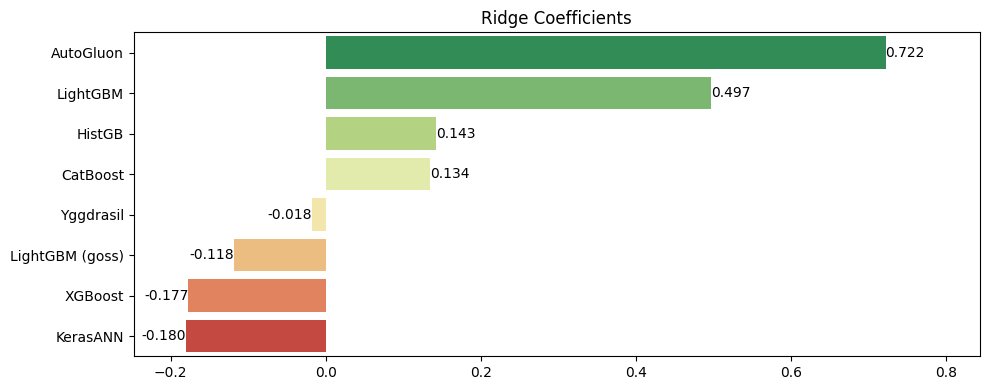

In [28]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [29]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Listening_Time_minutes
0,750000,53.695609
1,750001,18.262895
2,750002,47.844507
3,750003,77.679398
4,750004,46.456287


# Results

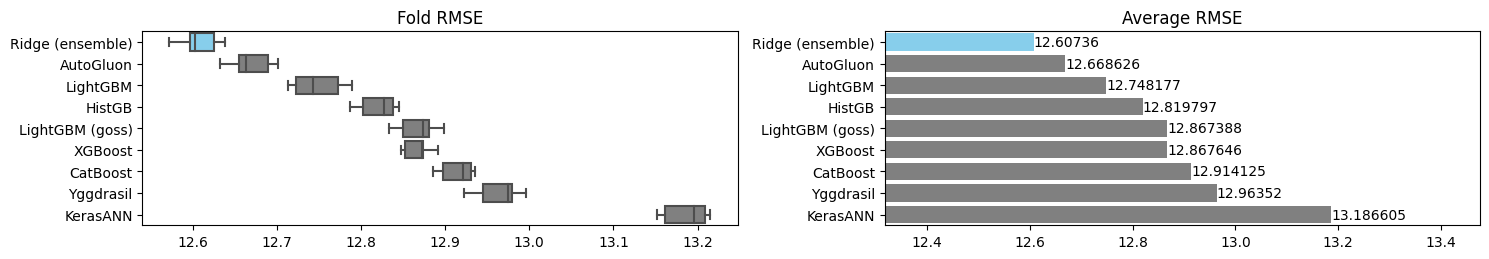

In [30]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "skyblue" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [31]:
shutil.rmtree("catboost_info", ignore_errors=True)